# User models in Sherpa

I was recently working on a way to charactrize the draws from a 
[MCMC chain](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) - in this
case generated with
[pyBLoCXS](http://cxc.harvard.edu/sherpa/ahelp/pyblocxs.html) but that's only relevant
here because we are interested in Poisson-distributed data, hence the Gamma function -
and came up with a simple user model for
[Sherpa](http://cxc.harvard.edu/sherpa/). I thought it would be make a good example case,
and decided to include an example of using the "low-level" API of Sherpa to fit data.

For this example I'm writing everything in an 
[IPython notebook](http://ipython.org/notebook.html), and the easiest way to do that
is to use the binary form of the 
[standalone Sherpa](http://cxc.cfa.harvard.edu/contrib/sherpa47/) release,
using 
[Anaconda Python](http://continuum.io/downloads):

```
% conda config --add channels https://conda.binstar.org/sherpa
% conda create -n sherpa_usermodel python=2.7 sherpa pyfits matplotlib scipy ipython-notebook
% source activate sherpa_usermodel
% mkdir notebooks
% ipython notebook --notebook-dir=`pwd`/notebooks
```

The code will also run in the [Sherpa provided with CIAO](http://cxc.harvard.edu/sherpa/) - although
in this case you would use 
[ChIPS](http://cxc.harvard.edu/chips/)
rather than matplotlib for plotting and would not have access to `scipy.stats` for
the simulation (try
[`numpy.random.gamma`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.gamma.html) 
instead) - as well
as if you have built the code directly from
https://github.com/sherpa/sherpa.

## Follow ups

I have written a follow-up to this, available at
[an integrated user model](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/an%20integrated%20user%20model.ipynb). This was written on May 4 2015.

I then had a brain wave and decided to talk about
[plotting in Sherpa when using the low-level API](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/plotting%20using%20the%20lower-level%20routines.ipynb). This was written on May 5 2015.

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on May 26 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository or on Twitter - at 
[@doug_burke](https://twitter.com/doug_burke) - if you have any questions. 

## Setting up

In [1]:
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

To make my testing easier, I fix the random seed. It's the same value as used by 
[Jake's AstroML book](http://www.astroml.org/book_figures/chapter3/fig_flux_errors.html),
but you may want to use a different value yourself ;-)

In [3]:
np.random.seed(1)

## Simulating some data

For this example, I am going to simulate values from a Gamma distribution using
[`scipy.stats.gamma`](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.gamma.html).
Following the 
[Wikipedia page](http://en.wikipedia.org/wiki/Gamma_distribution) I use the names `k` and `theta`
for the parameters of the distribution; fortunately they map onto the `a` and `scale` values used
by `scipy.stats.gamma`.

The mean of the distribution is just `k * theta`, so `2.86` here:

In [4]:
k_orig = 1.1
theta_orig = 2.6
ysim = scipy.stats.gamma.rvs(a=k_orig, scale=theta_orig, size=1000)

Let's have a quick look at the data:

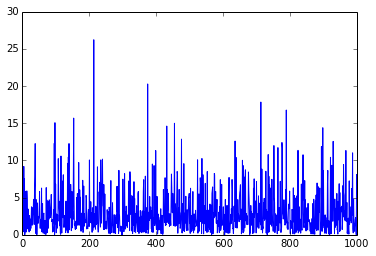

In [5]:
plt.plot(ysim)

(array([ 593.,  238.,  102.,   40.,   18.,    5.,    2.,    1.,    0.,    1.]),
 array([  8.86762636e-03,   2.62925028e+00,   5.24963293e+00,
          7.87001558e+00,   1.04903982e+01,   1.31107809e+01,
          1.57311635e+01,   1.83515462e+01,   2.09719288e+01,
          2.35923115e+01,   2.62126941e+01]),
 <a list of 10 Patch objects>)

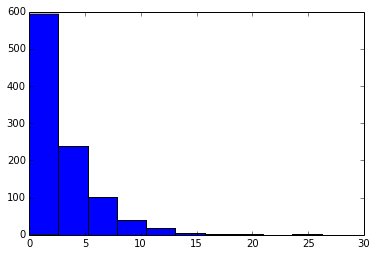

In [6]:
plt.hist(ysim)

For the work I was doing, I was interested in the 
[Cunulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_distribution_function),
so let's start by creating this for the data (`ysim`):

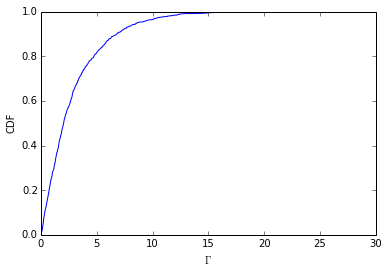

In [7]:
xcdf = ysim.copy()
xcdf.sort()
ycdf = np.arange(1, xcdf.size+1) * 1.0 / xcdf.size

plt.plot(xcdf, ycdf)
plt.xlabel('$\Gamma$')
plt.ylabel('CDF')

My aim is to fit this data, so I need a functional form for the CDF of
a Gamma distribution. Fortunately Sherpa provides the `igam` routine
which calculates what we need, so I can write the following (I could
have also used `scipy.stats` routines, but I wanted this to be usable
from Sherpa in CIAO):

In [8]:
import sherpa.utils

In [9]:
def calc_gamma_cdf(x, k, theta):
    """Return the CDF of a gamma distribution.

    The cumulative distribution function (CDF) of the gamma
    distribution is defined in [1]_ as::

       cdf(x;k,theta) = incomplete_gamma(k, x/theta)
                        ----------------------------
                                  gamma(k)

    Parameters
    ----------
    x : array
       The values at which to evaluate the CDF.
    k : number
       The shape parameter, which must be greater than 0.
    theta : number
       The scale parameter.

    Returns
    -------
    cdf : array
       The CDF evaluated at each element of x.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
 
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    # Unfortunately igam does not accept a Numpy array as the
    # second argument, so need to map over the input array.
    #
    tval = theta * 1.0
    kval = k * 1.0
    x = np.asarray(x)
    out = np.zeros_like(x)
    for i,xi in enumerate(x):
        # igam is the "regularized" incomplete gamma (lower)
        # form, so already has the normalization by gamma(a)
        # included.
        out[i] = sherpa.utils.igam(kval, xi/tval)

    return out

I can use this to plot the actual distribution on the simulated one:

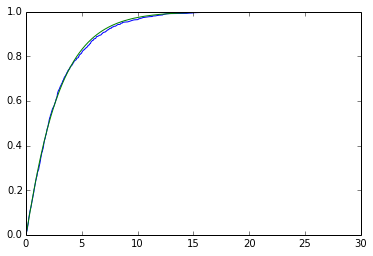

In [10]:
plt.plot(xcdf, ycdf)
plt.plot(xcdf, calc_gamma_cdf(xcdf, k_orig, theta_orig))

The [Quantile-Quantile plot](http://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)
also looks good (as it should here ;-):

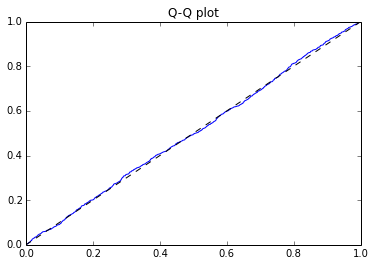

In [11]:
plt.plot(ycdf, calc_gamma_cdf(xcdf,k_orig,theta_orig))
plt.plot([0,1],[0,1], 'k--')
plt.title('Q-Q plot')

Using `calc_gamma_cdf` I can now create a Sherpa model that can be used to
fit the CDF data. Rather than use the
[`load_user_model` function](http://cxc.harvard.edu/sherpa/ahelp/load_user_model.html),
I have decided to use a class-based approach. The advantage is that this model then
behaves in the same manner as existing Sherpa models - so that you can create multiple
instances of it directly - at the expense of a little-more set-up work.

To do this, I need to import the Sherpa `sherpa.models.model` module.
In this case I am being explicit about the module names, to make it easier to see where
symbols are defined, but normally I would say something like

    from sherpa.models import model

In [12]:
import sherpa.models.model

With this, I can create the `GammaCDF` class. The model has two parameters, which 
I name `k` and `theta`, and set initial parameters and limits (the limit is inclusive,
which is not ideal here because both should be `> 0` rather than `>= 0`, but let's
see how this works). The important parts are `__init__`, which sets everything
up, and `calc` which is used to evaluate the model at a set of points. For this
example I am going to assume that if it is used with an "integrated" 1D data set - that
is, a data set where the signal is integrated between bin limits, rather than just
a value at a point - then the code should just use the mid-point of the bin. The
`modelCacher1d` function decorator tells the system that the results of the model can
be cached when all the parameter values are frozen (e.g. during a fit).

In "production" code, I'd include checks to make sure it's not used with a 2D data set!

In [13]:
class GammaCDF(sherpa.models.model.ArithmeticModel):
    """A Gamma CDF.

    The cumulative distribution function (CDF) for the Gamma
    distribution, as defined by [1]_, is::

       cdf(x;k,theta) = incomplete_gamma(k, x/theta)
                        ----------------------------
                                  gamma(k)

    The model parameters are:

    k
       The shape parameter, which must be greater than 0.

    theta
       The scale parameter.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
 
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    def __init__(self, name='gammacdf'):
        # It would be nice to force > 0 rather than >=0.
        # Perhaps should just use a small value, e.g. 
        # sherpa.models.parameter.tinyval?
        self.k = sherpa.models.model.Parameter(name, 'k', 5, min=0, hard_min=0)
        self.theta = sherpa.models.model.Parameter(name, 'theta', 2, min=0, hard_min=0)

        sherpa.models.model.ArithmeticModel.__init__(self, name, (self.k, self.theta))

    @sherpa.models.model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        (k, theta) = pars
        if len(args) == 1:
            x = (x + args[0]) / 2.0

        return calc_gamma_cdf(x, k, theta)


This model can be used to fit the data. I'll show this two ways

 1. using the low-level API, where data management is not automatic
 
 2. using the high-level UI which most users of Sherpa are used to.

## Managing the data directly

The UI that is explained in the 
[CXC Sherpa documentation](http://cxc.harvard.edu/sherpa/) deals with 
data management and state. However, this can be handled directly by
dropping down to the individual models and - for some cases, such as this
one - is very easy to do. Let's start with importing the symbols I need
(and to make it look easy, I'm not going to use the fully-qualified name approach I've
used so far):

In [14]:
from sherpa.data import Data1D
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar
from sherpa.fit import Fit

For this example - which is a 1D un-binned data set - we just need a name, and the independent and dependent data arrays. The name is only used to label the results in output structures, so here I just use the label `cdf`.

In [15]:
d = Data1D('cdf', xcdf, ycdf)

The model to be fit is - in this case - just a single component, the newly-created `GammaCDF`
model, so I need an instance (the name need not be the same as the variable name, but it makes tracking
things a bit easier!):

In [16]:
cdf = GammaCDF('cdf')

With these, I can now create a `Fit` object, selecting the statistic - I use the least-squared
version (`LeastSq`) since I have no errors - and the optimiser, for which I use the 
Levenberg-Marquardt method (as provided by the `LevMar` class):

In [17]:
f = Fit(d, cdf, LeastSq(), LevMar())

The fit can then be "run" and the output stored away. For this case the optimiser converged.

In [18]:
res = f.fit()
res.succeeded

True

The output of the `fit` method returns a lot if useful information, including the best-fit parameter values:

In [19]:
print(res)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = leastsq
succeeded      = True
parnames       = ('cdf.k', 'cdf.theta')
parvals        = (1.1022133409516357, 2.6102738001113779)
statval        = 0.0597900812602
istatval       = 230.646547311
dstatval       = 230.58675723
numpoints      = 1000
dof            = 998
qval           = None
rstat          = None
message        = successful termination
nfev           = 36


However, we can also access these values directly from the model:

In [20]:
print(cdf)

cdf
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   cdf.k        thawed      1.10221            0  3.40282e+38           
   cdf.theta    thawed      2.61027            0  3.40282e+38           


and compare them to the input values:

In [21]:
print(cdf.k.val, cdf.theta.val)
print(k_orig, theta_orig)

(1.1022133409516357, 2.6102738001113779)
(1.1, 2.6)


One down side to the low-level API is that plots have to be manually
created, but it's quite easy to create a residual (i.e. fit - data)
plot for the CDF:

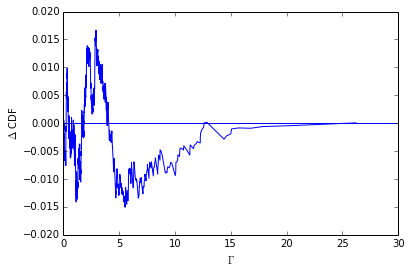

In [22]:
plt.plot(xcdf, ycdf - cdf(xcdf))
plt.axhline()
plt.ylabel('$\Delta$ CDF')
plt.xlabel('$\Gamma$')

The QQ plot looks good, as might be expected from the residuals:

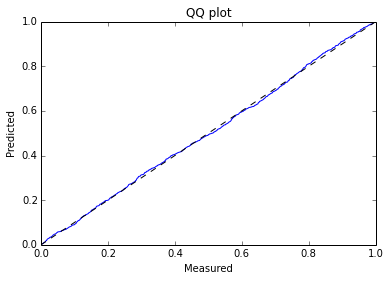

In [23]:
plt.plot(ycdf, cdf(xcdf))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('QQ plot')

## Letting Sherpa do all the work

The high-level API of Sherpa manages data and settings for users. In the
following I'm going to use the version provided by the `sherpa.ui` module,
but the "Astronomy-specific" module `sherpa.astro.ui` can also be used.

However, before doing this, I change the logging instance used by Sherpa so that
it doesn't create multiple copies of messages in the notebook. This is
an aesthetic issue and doesn't change the results shown here.

In [24]:
import logging
logging.getLogger('sherpa').propagate = 0

In [25]:
import sherpa.ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


The model needs to be added to Sherpa using `add_model`:

In [26]:
sherpa.ui.add_model(GammaCDF)

Let's select the least-square statistic, by name:

In [27]:
sherpa.ui.set_stat('leastsq')

Rather than create a `Data1D` object, here I use the default data set - which is
labelled `1`:

In [28]:
sherpa.ui.load_arrays(1, xcdf, ycdf)

The default behavior in plots is to display error bars, even when using a statistic like `leastsq`,
so I change this behavior before displaying the data (although, even with this setting, the code still
complains to you, which is something I need to send a bug report about):

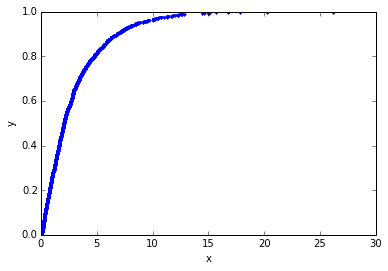

In [29]:
pprefs = sherpa.ui.get_data_plot_prefs()
pprefs['yerrorbars'] = False
sherpa.ui.plot_data()

The source model, used to describe the data, is set by `set_source`. Since `add_model` was used,
I can create an instance of the `GammaCDF` model using the syntax `modelname.cptname`, where
`modelname` is in lower case. To allow comparison with the eariler fit, I name the component
`cpt2`:

In [30]:
sherpa.ui.set_source(gammacdf.cdf2)

In [31]:
print(cdf2)

gammacdf.cdf2
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   cdf2.k       thawed            5            0  3.40282e+38           
   cdf2.theta   thawed            2            0  3.40282e+38           


The defailt optimiser is `LevMar`, so I do not need to set it - which would have been the following
call

    set_method('levmar')
    
Instead I can just go straight to fitting the data:

In [32]:
sherpa.ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 230.647
Final fit statistic   = 0.0597901 at function evaluation 36
Data points           = 1000
Degrees of freedom    = 998
Change in statistic   = 230.587
   cdf2.k         1.10221     
   cdf2.theta     2.61027     


and view the results:

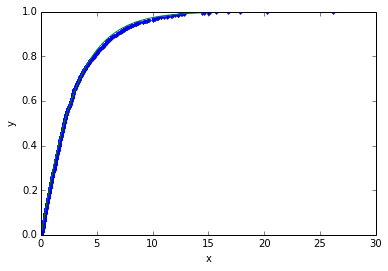

In [33]:
sherpa.ui.plot_fit()

Unfortunately it's not that obvious what is going on here, so let's look at the residual plot:

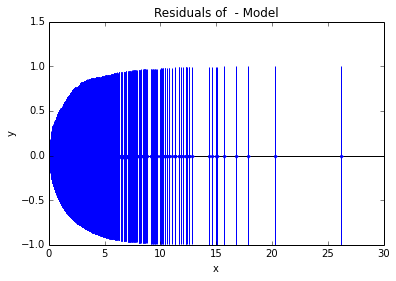

In [34]:
sherpa.ui.plot_resid()

Annoyingly, error bars are included (they are estimated from the dependent axis values assuming
Gaussian statistics, so are completely wrong in this case), and I do not know how to turn them off,
so I create the plot manually (I could use the same technique as earlier, and calculate the
residuals, but the UI includes a routine to return the plotted data):

In [35]:
resid = sherpa.ui.get_resid_plot()

and this can be used to create the residual plot, which should look familiar:

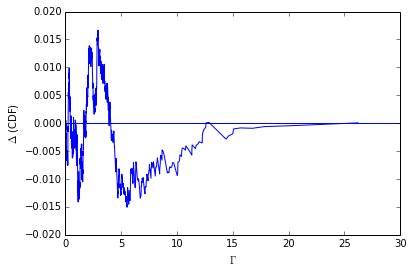

In [36]:
plt.plot(resid.x, resid.y)
plt.axhline()
plt.ylabel('$\Delta$ (CDF)')
plt.xlabel('$\Gamma$')

The results of the two fits should be the same (since the data, model, and starting points are the same). Are they?

In [37]:
print(cdf)
print(cdf2)

cdf
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   cdf.k        thawed      1.10221            0  3.40282e+38           
   cdf.theta    thawed      2.61027            0  3.40282e+38           
gammacdf.cdf2
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   cdf2.k       thawed      1.10221            0  3.40282e+38           
   cdf2.theta   thawed      2.61027            0  3.40282e+38           


Phew. So, I hope you enjoyed this whistle-stop tour through Sherpa user models, the
`add_model` command, and direct access to the low-level API provided by Sherpa.

## A follow up (May 4 2015)

I have written a follow-up to this, available at
[an integrated user model](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/an%20integrated%20user%20model.ipynb).